In this notebook we are going to perform focused docking in the Sudlow I binding site. The workflow is very similar to one for the blind docking.

# Import libraries

In [22]:
import numpy as np
import os
import glob
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.vq import kmeans2
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import set_matplotlib_formats
import MDAnalysis as mda
import chilife as xl

set_matplotlib_formats('retina')

# Set paths
This section takes .mol2 files from working directory (HOME) of your project and generates MD and docking topologies. .mol2 files with partial charges can be obtained from ORCA calculations.

1. The HOME directory contains folders Params (with original .mol2 file and where topologies will be saved), Docking (where docking will take place) and MD (where ligand topologies will be put for further molecular dynamics). The single HOME directory is used for different ligands, for which separate subfolders are created. You have to create file with the name of your ligand in Params, MD and Docking folders.

2. The REPOSITORY directory contains additional .py files used for docking. It can be set to this Github repository or something else.

3. The RECEPTOR directory contains the .pdb structure of your receptor and .xyz center file for the center of the docking box. In case of blind docking you need to set blind_center.xyz in the same format as an example. If you want to use different site, you have to create {name_site}_center.xyz and etc. You can create an atom in PyMol at required position and save its xyz coordinates to create this file. 

4. You need to set PATH_ADFR path to the bin folder of your local AutoDock-GPU installation.

5. In addition you should set paths for acpype and in prep_lig.py files

In this example we are going to use the tcpp.mol2 file with optimized structure and calculated partial charges. The receptor.pdb file is taken from 1AO6 PDB code.

Since we are doing focused docking, we are going to rename the site_name to "sud1". The site_name has to be the same as the name of the file with the center of the docking box "sud1_center.xyz"

In [12]:
NAME = "tcpp" # Name of the ligand to be docked
site_name = "sud1" # Name of the pocket for the flex docking. 'blind' - blind docking and etc.

work_path = f"/home/biomd/Documents/GitHub/EPR-BindingSite" # development directory, replace or delete on different computers
HOME = f"{work_path}/Examples/" # Full path to working directory
REPOSITORY = f"{work_path}/Scripts/" # Full path to the folder containing scripts
PATH_TO_DOCKING = f"{HOME}/Docking/{NAME}"
PATH_TO_MD = f"{HOME}/MD/{NAME}"
PATH_TO_MOL2 = f"{HOME}//Params/{NAME}"
RECEPTOR_PATH = f"{HOME}/Receptor/"

PATH_ADFR = f"/home/biomd/ADFRsuite-1.0/bin" # Path to the ADFRSuite/bin package
PYTHONSH = f"{PATH_ADFR}/pythonsh" # Path to the ADFRSuite pythonsh

TARGET_PATH = PATH_TO_DOCKING


if not os.path.exists(RECEPTOR_PATH):
        print(f"RECEPTOR directory does not exist.")
else:
    os.system(f"cp -r {RECEPTOR_PATH}/* {TARGET_PATH}/")

In this section we are going to set names for our working files, such as the name of the receptor file, site where we will dock and flexible residues (in case of flexible docking).

Here we are going to perform flexible focused docking in the Sudlow I site. In residues_dict we have to set names and id's of residues whose side-groups we want to be flexible during docking.

Keep in mind that flexible docking takes considerably more time that rigid docking. Usually you can only choose 5-6 flexible residues until you run out of memory, but that depends on your system.

In [5]:
ligand_file = f"{NAME}_wat_charged.pdbqt" # Final name of the ligand .pdbqt file to be generated
receptor_name = 'receptor' # Name of the receptor

receptor_file_pdb = receptor_name+'.pdb' # Name of the receptor (protein) .pdb file
receptor_file = receptor_name+'.pdbqt' # Receptor .pdbqt file


grid_name = f"{site_name}_site"
center_file = f"{site_name}_center.xyz" #.xyz file containing the coordinates for the center of the search space

# dict of flexible receptor residues used for flexible docking in format "ARG114_ARG117_..."
residues_dict = { #
    'noflex':"",
    # You can calculate the same for the Heme site if you want, just change sud1 to heme!
    'heme':"ARG114_ARG117_ASP183_ASP187_ARG186_VAL116_LEU115",
    
    'sud1': "LYS195_LYN199_ARG218_ARG222_GLU292_SER192_LYS436_TRP214_GLU188",
}
if site_name in ["sud1", "heme"]: # list of sites where flexible docking will be used
    flex_residues = residues_dict[site_name]
else:
    flex_residues = residues_dict['noflex']

# Preparation and docking

## Run parametrization of ligands

This section is the same as for the blind docking, so you can skip it if you have done it before.

In [6]:
SCRIPT_PARAM_LIGAND = f"{REPOSITORY}/prep_lig.py" # The script for parametrization of GAFF2 ligand for MD and preparation of folders

SCRIPT_LIGAND_DOCK = f"{REPOSITORY}/prep_wat.py" # The script of preparation of ligand for docking, in this case we use hydrated docking

os.chdir(PATH_TO_MOL2)
# Perform GAFF2 parametrization and put files in proper places
os.system(f"python3 {SCRIPT_PARAM_LIGAND} {NAME}.mol2 {PATH_TO_DOCKING} {PATH_TO_MD} {PATH_ADFR}")

os.chdir(PATH_TO_DOCKING)
# Perform ligand parametrization for docking
os.system(f"python3 {SCRIPT_LIGAND_DOCK} {PATH_ADFR} {NAME}.mol2")

Paths are NAME=tcpp PATH_TO_DOCKING=/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//Docking/tcpp PATH_TO_MD=/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//MD/tcpp
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2023.11.14 (c) 2025 AWSdS |
==> Reading user's charges from mol2 file...
==> ... charge set to -4
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
==> * Tleap OK *
==> Removing temporary files...
==> Using OpenBabel v.3.1.0

==> Writing NEW PDB file

==> Writing CNS/XPLOR files

==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Writing CHARMM files

==> Overwriting pickle file tcpp.pkl
==> Removing temporary files...
Total time of execution: 1s
Generated GAFF2 topologies for tcpp!
Moved resulting files in folders for tcpp!


mkdir: cannot create directory ‘tcpp_export’: File exists


/home/biomd/Documents/GitHub/EPR-BindingSite/Examples/Docking/tcpp
tcpp.mol2
Input molecule charges: [['O51' '-0.413']
 ['O52' '-0.415']
 ['O53' '-0.417']
 ['O54' '-0.417']
 ['O55' '-0.419']
 ['O56' '-0.421']
 ['O57' '-0.417']
 ['O' '-0.419']
 ['N01' '-0.065']
 ['N02' '-0.050']
 ['N03' '-0.197']
 ['N' '-0.176']
 ['C04' '0.062']
 ['C05' '0.077']
 ['C06' '0.063']
 ['C07' '0.053']
 ['C08' '0.063']
 ['C09' '-0.002']
 ['C10' '0.037']
 ['C11' '0.087']
 ['C12' '-0.012']
 ['C13' '-0.000']
 ['C14' '0.035']
 ['C15' '0.026']
 ['C16' '-0.031']
 ['C17' '-0.042']
 ['C18' '-0.079']
 ['C19' '-0.062']
 ['C20' '0.126']
 ['C21' '-0.025']
 ['C22' '-0.042']
 ['C23' '0.037']
 ['C24' '-0.052']
 ['C25' '-0.058']
 ['C26' '-0.018']
 ['C27' '-0.043']
 ['C28' '-0.099']
 ['C29' '-0.036']
 ['C30' '-0.096']
 ['C31' '-0.039']
 ['C32' '-0.028']
 ['C33' '-0.068']
 ['C34' '-0.029']
 ['C35' '-0.053']
 ['C36' '-0.088']
 ['C37' '-0.073']
 ['C38' '-0.088']
 ['C39' '-0.075']
 ['C40' '-0.071']
 ['C41' '-0.076']
 ['C42' '-0.07

0

Here in addition to prepare_receptor from ADFR we are going to use prepare_flexreceptor from AutoDock Vina.

In [14]:
! {PATH_ADFR}/prepare_receptor -r {receptor_file_pdb} -o {receptor_file} -v -A checkhydrogens
if (flex_residues != ""):
    ! {PYTHONSH} {REPOSITORY}/vina_scripts/prepare_flexreceptor.py -r {receptor_file} -s {flex_residues} -v
    ! mv {receptor_name}_flex.pdbqt {site_name}.pdbqt
    rigid_receptor_name = f"{receptor_file.split('.pdbqt')[0]}_rigid.pdbqt"

set verbose to  True
set repairs to  checkhydrogens
read  receptor.pdb
setting up RPO with mode= automatic and outputfilename=  receptor.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide
set verbose to True
read  receptor.pdbqt
Specified flexres selection strings are:
   LYS195_LYN199_ARG218_ARG222_GLU292_SER192_LYS436_TRP214_GLU188
selecting  LYS195_LYN199_ARG218_ARG222_GLU292_SER192_LYS436_TRP214_GLU188
res_names= ['LYS195', 'LYN199', 'ARG218', 'ARG222', 'GLU292', 'SER192', 'LYS436', 'TRP214', 'GLU188']
looking for   LYS195
 added  ['LYS195']  to  [<Residue instance> receptor:A:LYS195 with 13 MolKit.molecule.Atom]
looking for   LYN199
looking for   ARG218
 added  ['ARG218']  to  [<Residue instance> receptor:A:LYS195 with 13 MolKit.molecule.Atom, <Residue instance> receptor:A:ARG218 with 17 MolKit.molecule.Atom]
looking for   ARG222
 added  ['ARG222']  to  [<Residue instance> receptor:A:LYS195 with 13 MolKit.molecule.Atom, <Residue

Prepare grid file

In [15]:
SIZE = 100 # Size of the docking box in Autodock units (default unit is 0.375 A). Maximum size is 255 units
os.chdir(PATH_TO_DOCKING)

# Optional: delete all files in the docking folder before running it again
clear_grid = False
if clear_grid:
    ! rm -rf {grid_name}*/*run*
    ! rm -rf {grid_name}*/*entity*
    ! rm -rf {grid_name}*/cluster*
    ! rm -rf {grid_name}*/*xml
    ! rm -rf {grid_name}*/*dlg

And run the Docking!

The script gen_grids generates grid files for all atom types of ligand and water and then accordingly modifies the map files. run_adgpu runs AutoDock-GPU and creates pose files with information on their energy and population. 

Simply copy printed commands and put them in the terminal in the main directory for docking of your ligand (running commands directly from Jupyter significantly worsens the perfomance).


Here we are going to perform only 1000 runs. It's going to take a long time! (~30 min)

In [16]:
NRUNS = 1000 # Number of docking runs: 1-8192
HEUR = 0 # Number of evaluations - optional. Set 0 for default.

if flex_residues != "":
    print(f"python3 {REPOSITORY}/gen_grids.py {PYTHONSH} {center_file} {rigid_receptor_name} {ligand_file} {SIZE} {REPOSITORY} {grid_name}")
    # An additional copy
    print(f"cp {site_name}.pdbqt {grid_name}1/")
    if(HEUR > 0):
        print(f"python3 {REPOSITORY}/run_adgpu_flex.py {rigid_receptor_name} {ligand_file} {NRUNS} 1 {site_name}.pdbqt {grid_name} {HEUR}")
    else:
        print(f"python3 {REPOSITORY}/run_adgpu_flex.py {rigid_receptor_name} {ligand_file} {NRUNS} 1 {site_name}.pdbqt {grid_name}")
else:
    print(f"python3 {REPOSITORY}/gen_grids.py {PYTHONSH} {center_file} {receptor_file} {ligand_file} {SIZE} {REPOSITORY} {grid_name}")
    if HEUR >0:
        print(f"python3 {REPOSITORY}/run_adgpu.py {receptor_file} {ligand_file} {NRUNS} 1  {grid_name} {HEUR}")
    else:
        print(f"python3 {REPOSITORY}/run_adgpu.py {receptor_file} {ligand_file} {NRUNS} 1  {grid_name}")

python3 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts//gen_grids.py /home/biomd/ADFRsuite-1.0/bin/pythonsh sud1_center.xyz receptor_rigid.pdbqt tcpp_wat_charged.pdbqt 100 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts/ sud1_site
cp sud1.pdbqt sud1_site1/
python3 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts//run_adgpu_flex.py receptor_rigid.pdbqt tcpp_wat_charged.pdbqt 1000 1 sud1.pdbqt sud1_site


This time have obtained a smaller number poses in one binding site. Therefore, we don't need to perform any additional clustering of results.

Instead, we can calculate theorethical distance distributions from each highly-populated pose and compare it with experimental

# Analysis of results

## Parse results of docking 

We are still going to filter out low-populated poses.

['/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//Docking/tcpp/sud1_site1']
['<cluster cluster_rank="1" lowest_binding_energy="-22.56" run="542" mean_binding_energy="-19.98" num_in_clus="224"/>', '<cluster cluster_rank="2" lowest_binding_energy="-20.33" run="751" mean_binding_energy="-17.87" num_in_clus="64"/>', '<cluster cluster_rank="3" lowest_binding_energy="-19.69" run="739" mean_binding_energy="-16.82" num_in_clus="699"/>', '<cluster cluster_rank="4" lowest_binding_energy="-18.89" run="916" mean_binding_energy="-17.80" num_in_clus="12"/>', '<cluster cluster_rank="5" lowest_binding_energy="-16.77" run="629" mean_binding_energy="-16.77" num_in_clus="1"/>']
Sum of population in obtained poses 987
Obtained 3 poses
cd sud1_site1; disable all; load cluster3_-19.69_p699.pdbqt; load cluster1_-22.56_p224.pdbqt; load cluster2_-20.33_p64.pdbqt;  cd ..; group sud1_25_1, enabled


/tmp/ipykernel_3160518/2622724992.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3160518/2622724992.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_full.show()


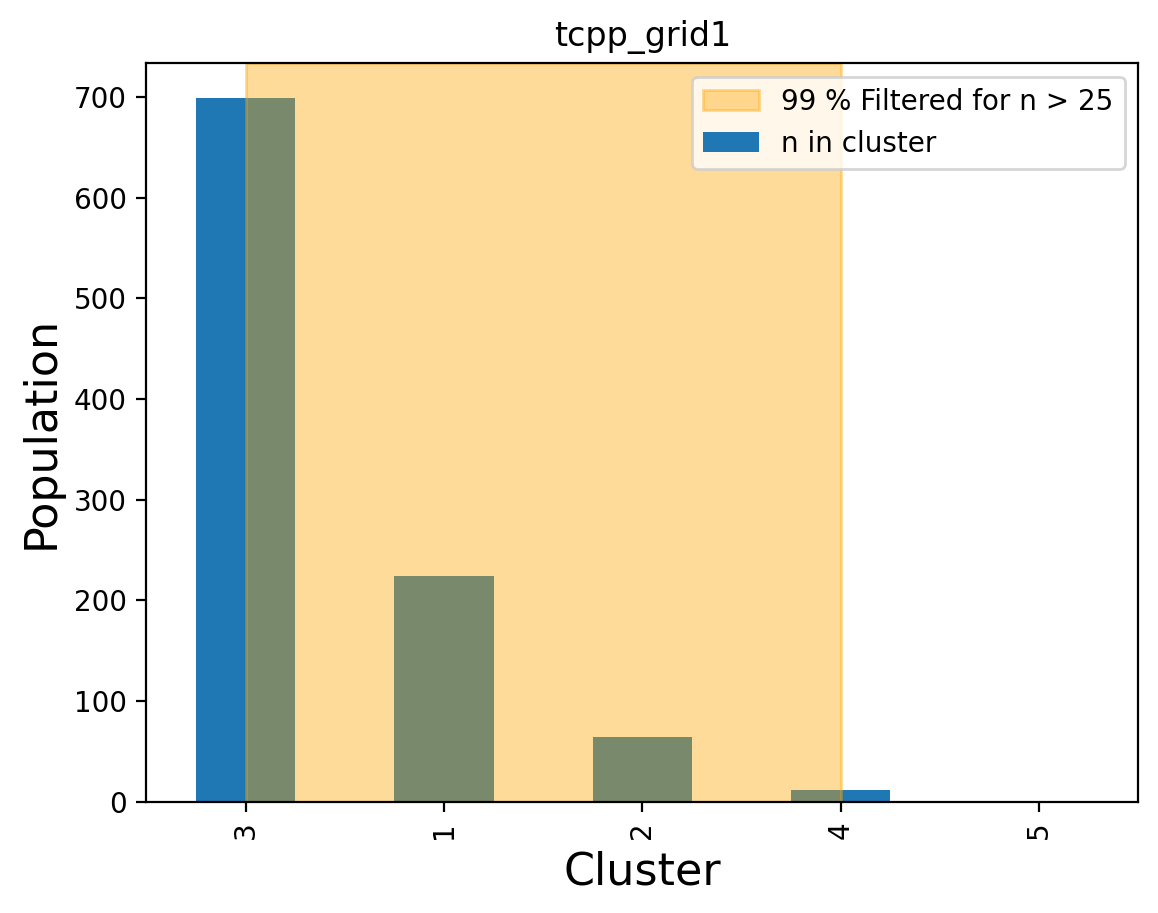

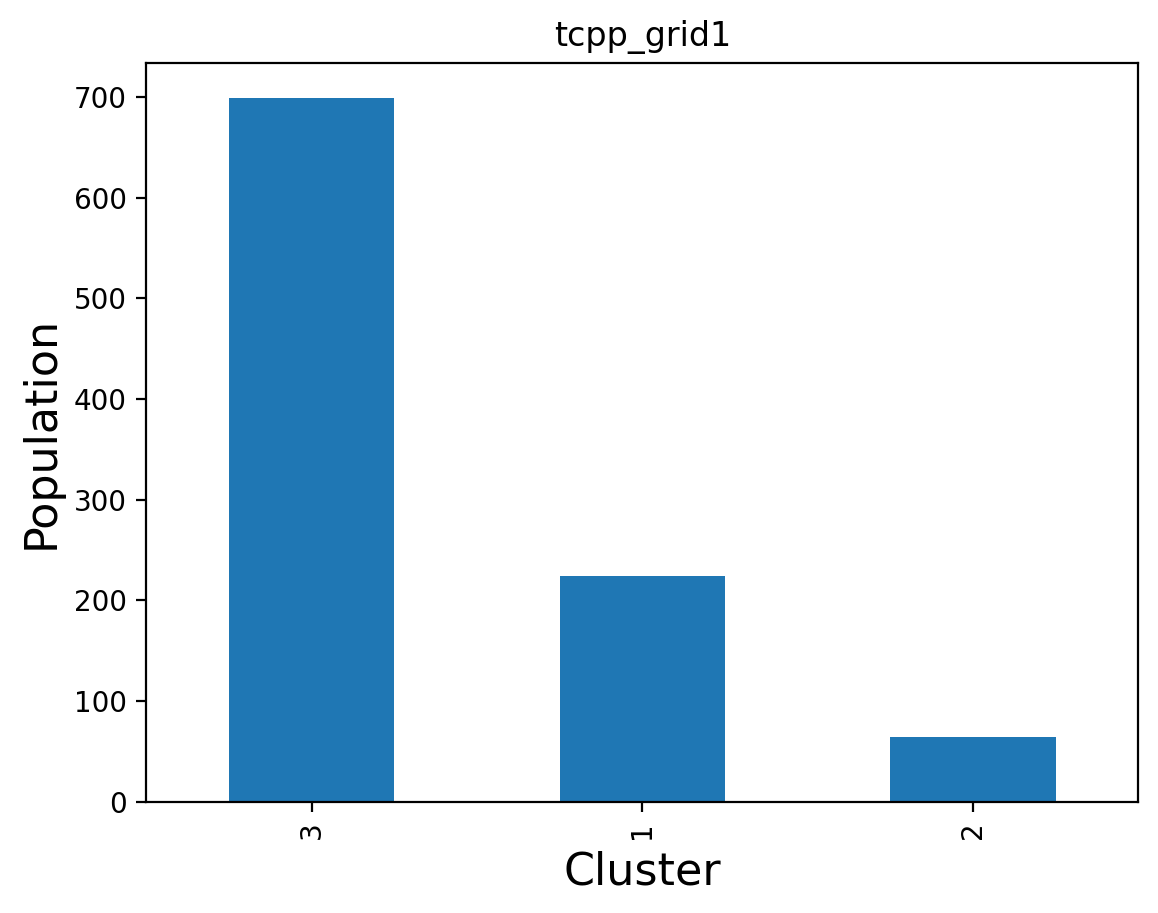

In [17]:
dataname=NAME # name of the ligand
FOLDNAME = NAME

iffilter = True
n_filter = 25 # Threshold of pose population to be filtered. Only poses with population more than n_filter will be considered
centers = glob.glob(f"{TARGET_PATH}/{grid_name}*")
i=0
print(centers)


k=0
fig_full = plt.figure(dpi=100) # Figure of all poses
fig = plt.figure(dpi=100) # Figure showing filtrated poses
pymol_load = [f'cd {grid_name}{i+1}; disable all; ' for i in range(1)]
for cent in centers:
	os.chdir(f"{TARGET_PATH}/{grid_name}{i+1}")
	# get parameters of poses
	energy = subprocess.getoutput("awk '/RANKING/ {if ($1==1 && $2==1) print $4;}' *.dlg")
	runs = glob.glob(f"{os.getcwd()}/*_run*")
	clusters = subprocess.getoutput("xmllint --xpath '//result/clustering_histogram/cluster' *.xml")
	# print(clusters)
	clusters = clusters.split("\n")
	print(clusters)
	cluster = np.empty(len(clusters),dtype = int)
	run_energy = np.empty(len(clusters),dtype = float)
	run = np.empty(len(clusters),dtype = int)
	nclust = np.empty(len(clusters),dtype = int)
	clustfile = np.empty(len(clusters),dtype = object)
	clustfile_pdb = np.empty(len(clusters),dtype = object)
	for idx, cl in enumerate(clusters):
		cl = cl.split()
		cluster[idx] = cl[1].split("=")[1].replace('"','')
		run_energy[idx] = cl[2].split("=")[1].replace('"','')
		run[idx] = cl[3].split("=")[1].replace('"','')
		nclust[idx] = cl[5].split("=")[1].replace("/>",'').replace('"','')
		clustfile[idx] = f"cluster{cluster[idx]}_{run_energy[idx]}_p{nclust[idx]}.pdbqt"
		clustfile_pdb[idx] = f"cluster{cluster[idx]}_{run_energy[idx]}_p{nclust[idx]}.pdb"
	# Get dataframe of docking results
	clust_data = pd.DataFrame(data={'cluster':cluster,'energy':run_energy, 'nrun':run, 'n in cluster':nclust, 'clusterfile':clustfile, 'clusterfile_pdb':clustfile_pdb})
	clust_data = clust_data.sort_values(by=['n in cluster'], ascending=False)
	# Filter poses
	if iffilter:
		clust_data_filter=clust_data.query(f'`n in cluster` >={n_filter}')
	# Plot populations of each pose
	ax = fig_full.add_subplot(1,1,1)
	clust_data.plot.bar(x='cluster', y='n in cluster', ax=ax, legend=False)
	ax.axvspan(0, len(clust_data_filter), color='orange', alpha=0.4,
	 label = f"{round(clust_data_filter['n in cluster'].sum()/clust_data['n in cluster'].sum()*100)} % Filtered for n > {n_filter}")
	ax.legend()
	rects = ax.patches
	labels = clust_data['energy']
	for rect, label in zip(rects, labels):
		height = rect.get_height()
		# ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')
	ax.set_title(f"{dataname}_grid{i+1}")

	ax2 = fig.add_subplot(1,1,1)
	clust_data_filter.plot.bar(x='cluster', y='n in cluster', ax=ax2, legend=False)
	
	rects = ax2.patches
	labels = clust_data_filter['energy']
	for rect, label in zip(rects, labels):
		height = rect.get_height()
		# ax2.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')
	
	ax2.set_title(f"{dataname}_grid{i+1}")
	for file in clust_data_filter['clusterfile']:
		pymol_load[i]+=f"load {file}; "
	i+=1
	print(f"Sum of population in obtained poses {clust_data_filter['n in cluster'].sum()}")
fs=16
ax.set_xlabel("Cluster", fontsize=fs)
ax.set_ylabel("Population", fontsize=fs)
ax2.set_ylabel("Population", fontsize=fs)
ax2.set_xlabel("Cluster", fontsize=fs)
fig.show()
fig_full.show()

name_pymol = f"{site_name}_{n_filter}_"
# Generate PyMol command to load all filtered results of docking in session
for idx,s in enumerate(pymol_load):
	pymol_load[idx]+=f" cd ..; group {name_pymol}{idx+1}, enabled"
print(f"Obtained {len(clust_data_filter)} poses")
# print("\n".join(pymol_load))
print("; ".join(pymol_load))

You should get something like this 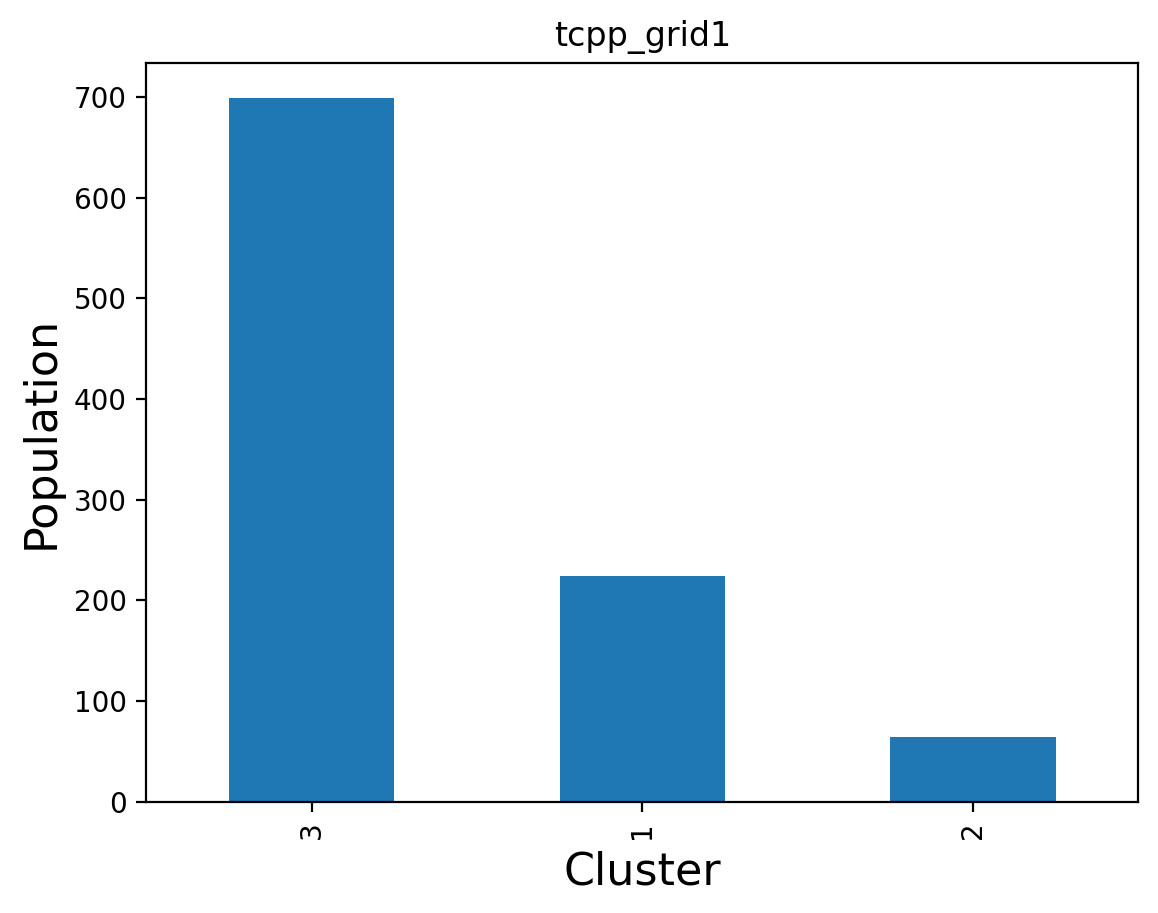

### Save chosen poses as pdb files

In [18]:
clusters_folder = f"clusters_{n_filter}"
docked_poses = []
os.chdir(f"{TARGET_PATH}/{grid_name}1")
if not(os.path.exists(clusters_folder) and os.path.isdir(clusters_folder)):
    os.makedirs(clusters_folder)
for file in clust_data_filter['clusterfile']:
    os.system(f"obabel -ipdbqt {file} -opdb > {clusters_folder}/{file.split('.pdbqt')[0]}.pdb")

8 molecules converted
8 molecules converted
8 molecules converted


# Visualize results

In [19]:
# Path to the *distr.dat file from DeerAnalysis
distr_file = f"{HOME}/TCPP/TCPP_Distribution.dat"
distr = np.loadtxt(glob.glob(distr_file)[0])
distr[:,1], distr[:,2], distr[:,3] = distr[:,1]/max(distr[:,1]), distr[:,2]/max(distr[:,1]), distr[:,3]/max(distr[:,1])
distr[:,0] = distr[:,0]*10

In [20]:
clust_data_filter

,cluster,energy,nrun,n in cluster,clusterfile,clusterfile_pdb
2,3,-19.69,739,699,cluster3_-19.69_p699.pdbqt,cluster3_-19.69_p699.pdb
0,1,-22.56,542,224,cluster1_-22.56_p224.pdbqt,cluster1_-22.56_p224.pdb
1,2,-20.33,751,64,cluster2_-20.33_p64.pdbqt,cluster2_-20.33_p64.pdb


Here we use the ChiLife library to calculate average distances from selected poses to the spin label

In [23]:
forgive = 1 # Set forgiveness factor for the spin label (how strict are the clashes treated)

os.chdir(f"{PATH_TO_DOCKING}")
rec = mda.Universe(f"{PATH_TO_DOCKING}/{receptor_name}.pdb") # Load receptor
# Generate Spin Label conformations
class CustomEnergyFunc(xl.ljEnergyFunc):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ljFunc = super().__call__
        self.func_forgive = forgive

    def __call__(self, rotens):
        ljE = self.ljFunc(rotens, forgive=self.func_forgive)
        return ljE 


my_energy_func = CustomEnergyFunc(functional=xl.get_lj_energy)

SL_label = xl.SpinLabel('R1M', site=34, protein=rec, dihedral_sigmas=np.inf,
                         sample=40000, energy_func = my_energy_func, use_H = False)
print(f"{len(SL_label)} Spin Conformations")
# Save protein with modeled spin labels
# xl.save(f"{receptor_name}_withSL.pdb", SL_label, rec, write_spin_centers=False)
# xl.save(f"{receptor_name}_onlySL.pdb", SL_label, write_spin_centers=False)

7 Spin Conformations


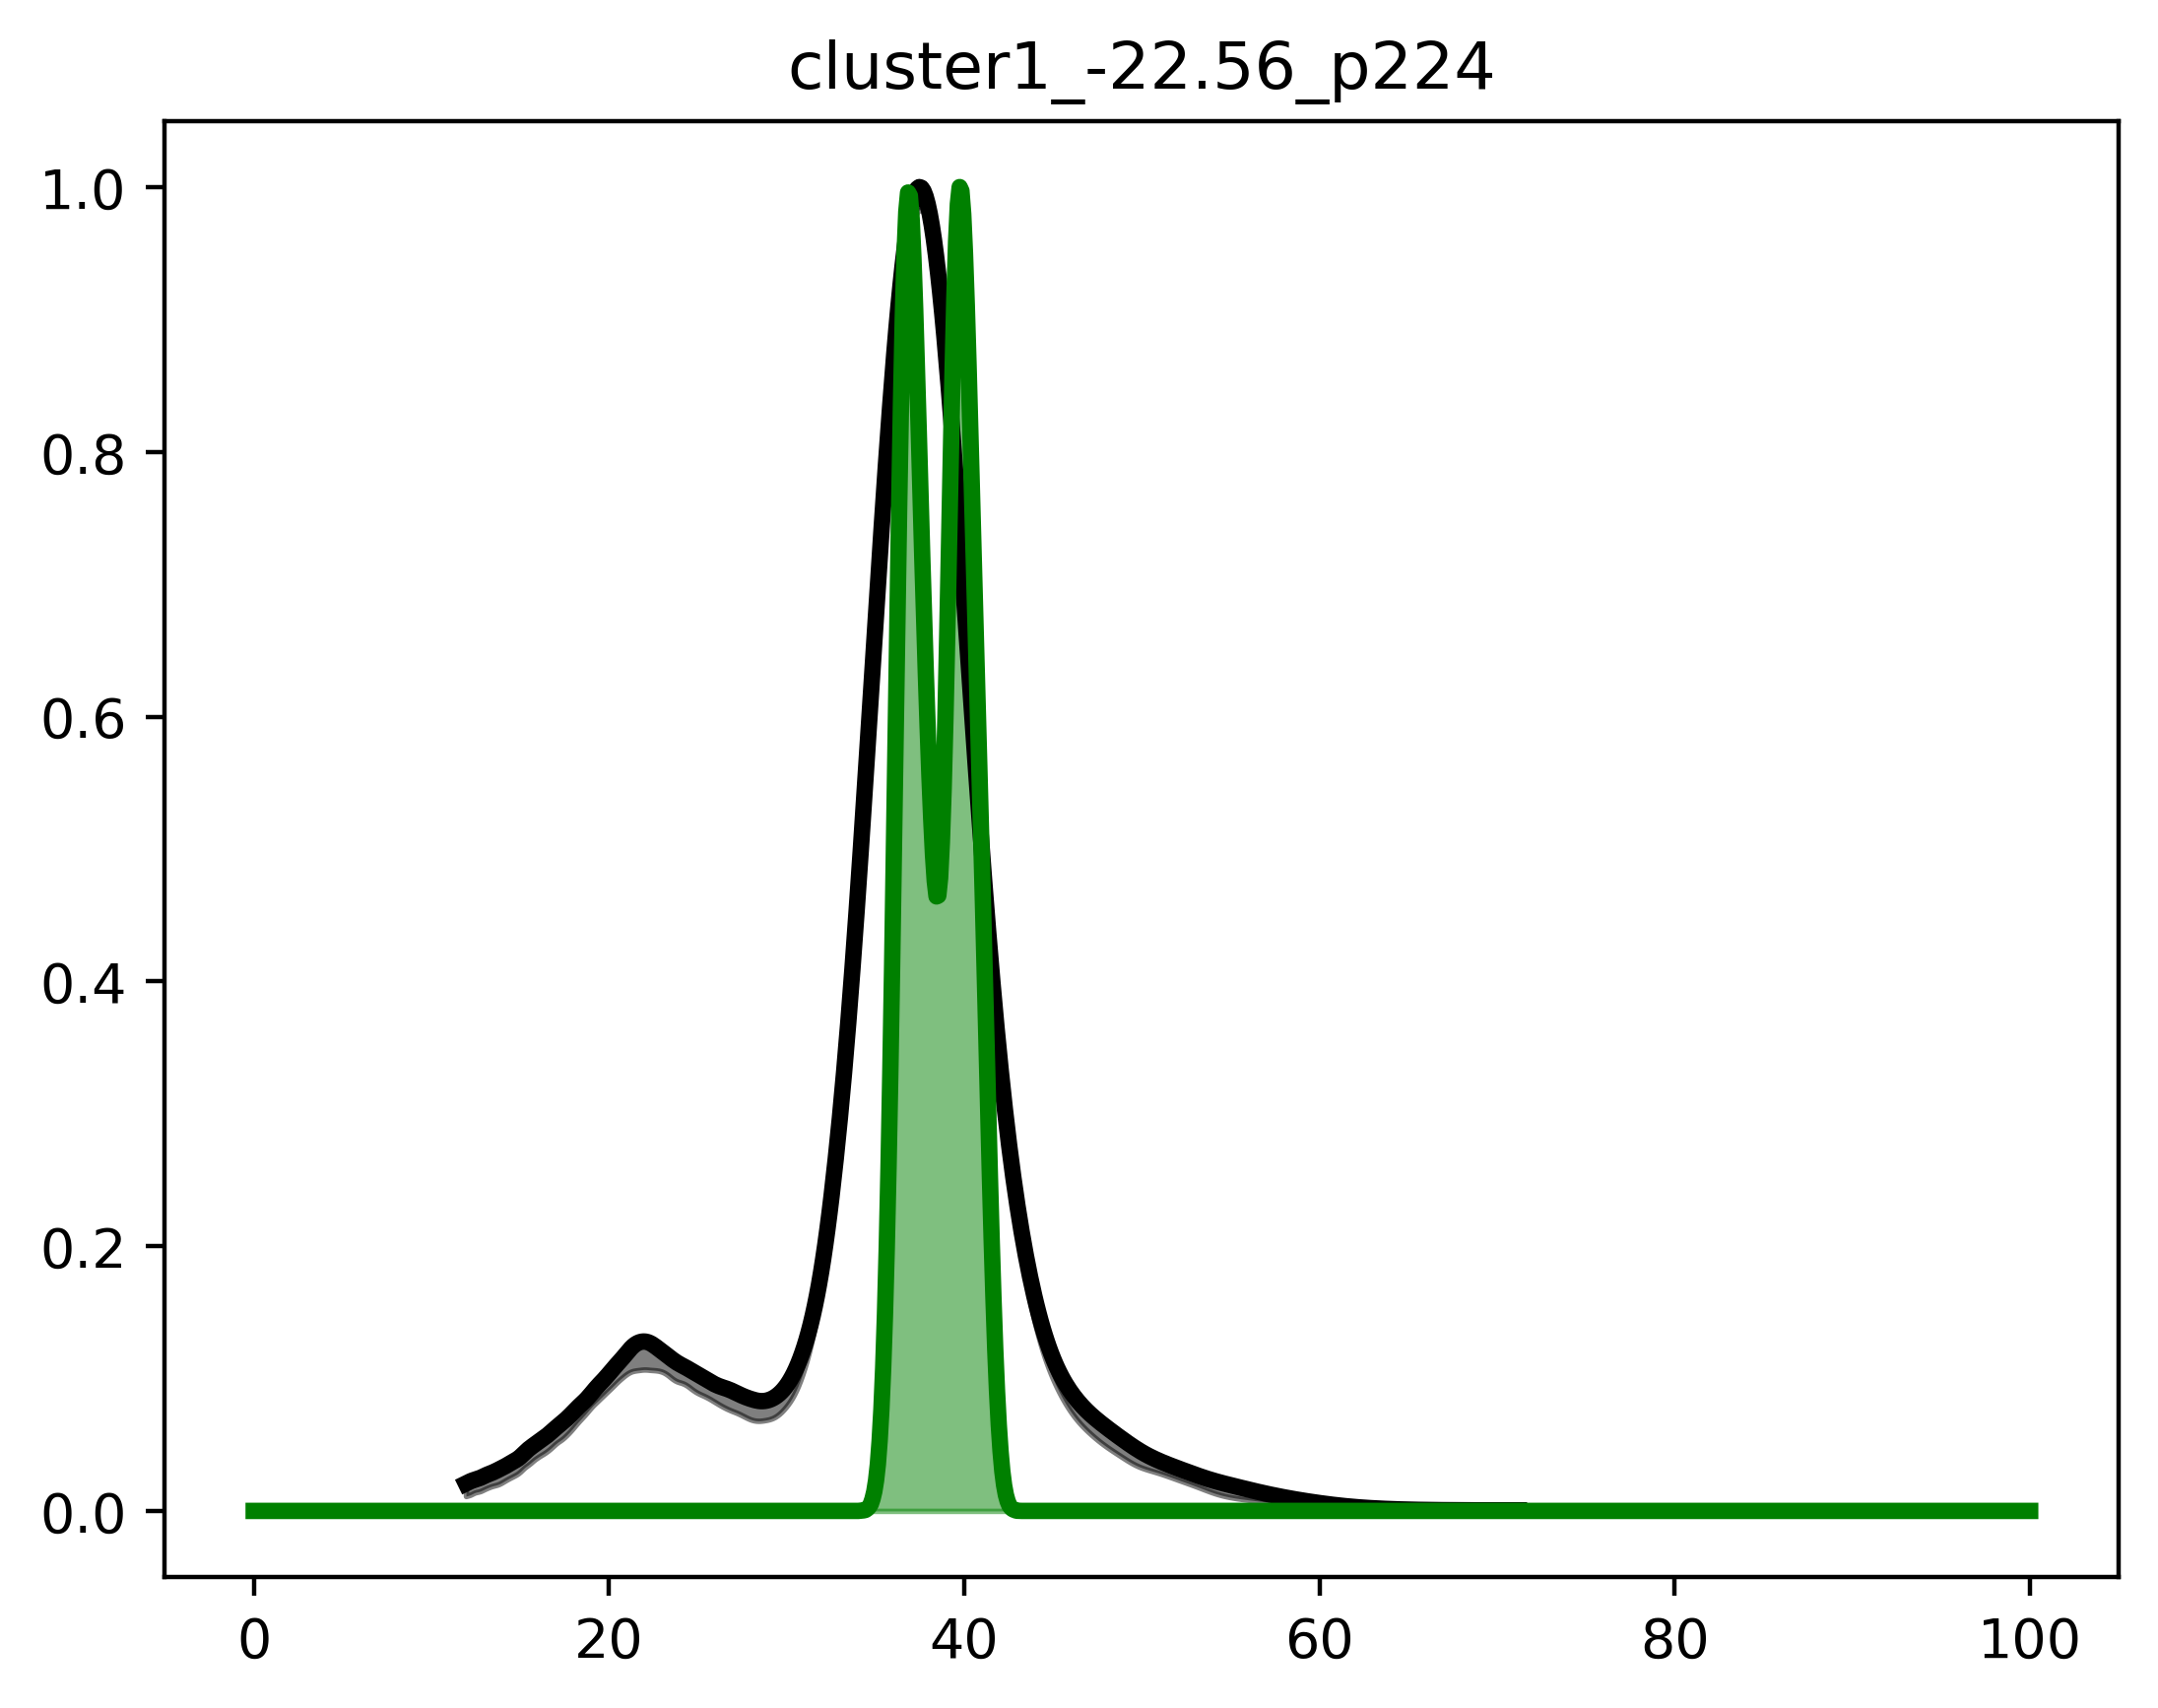

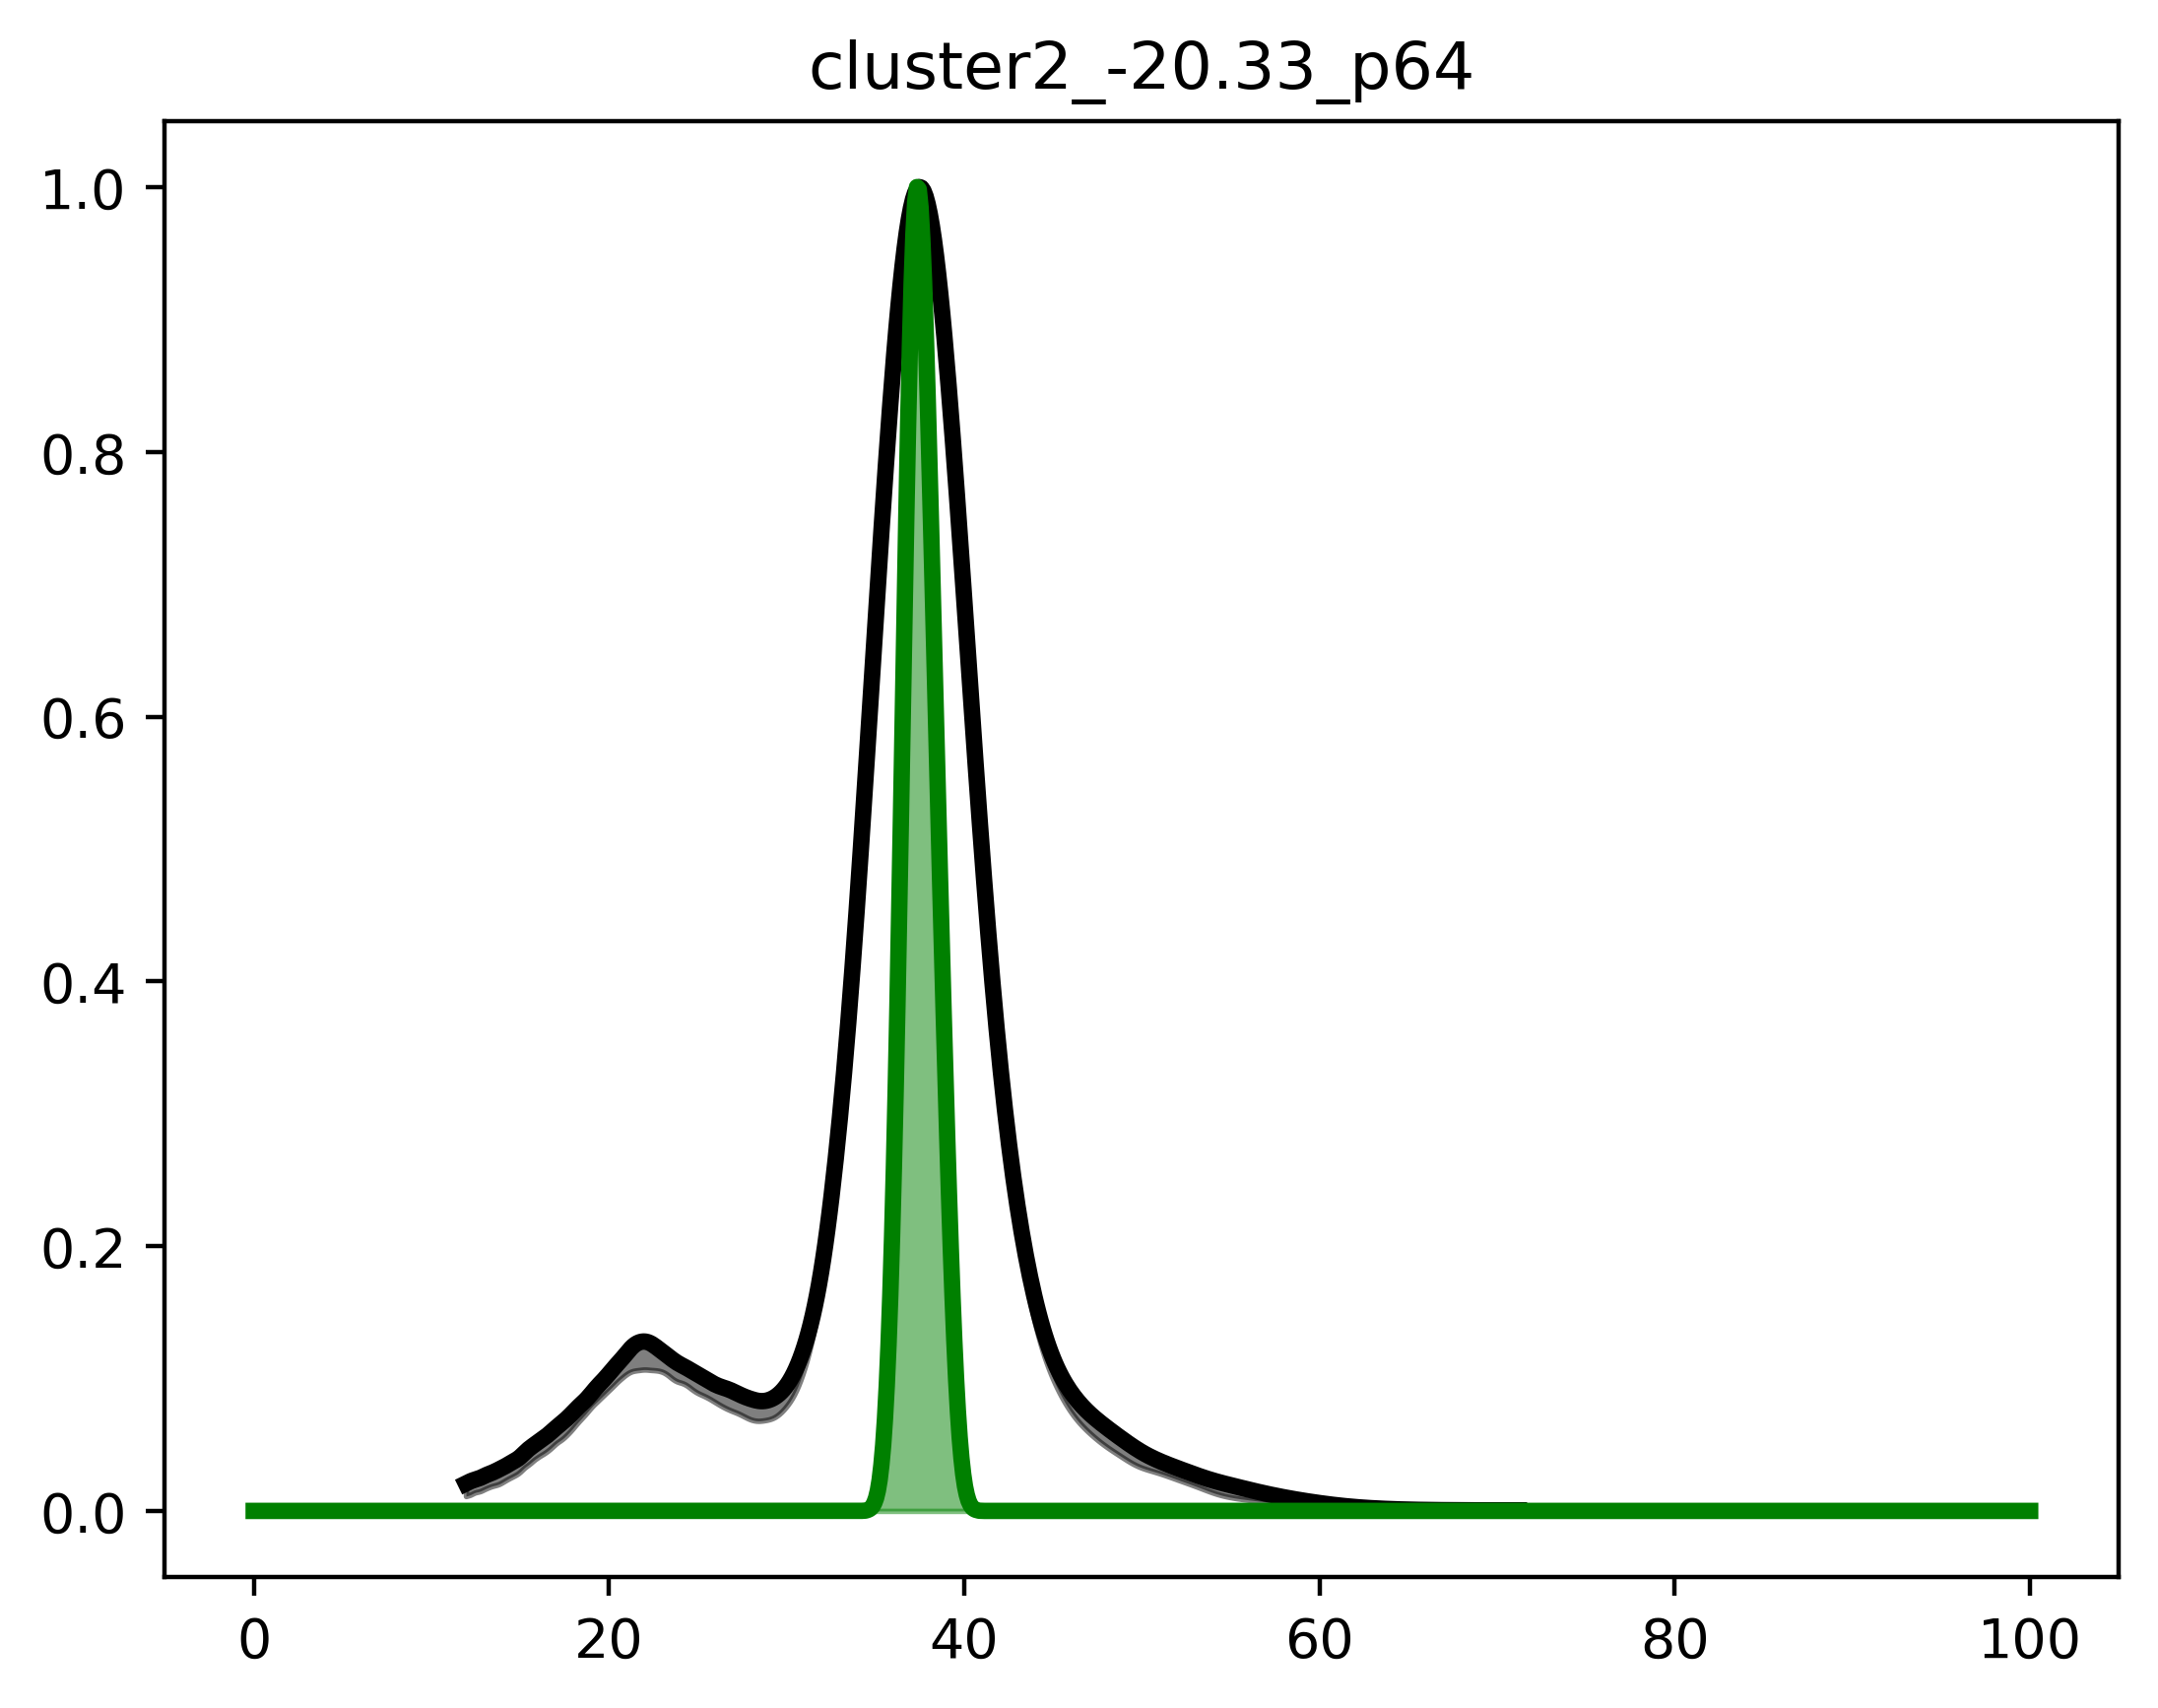

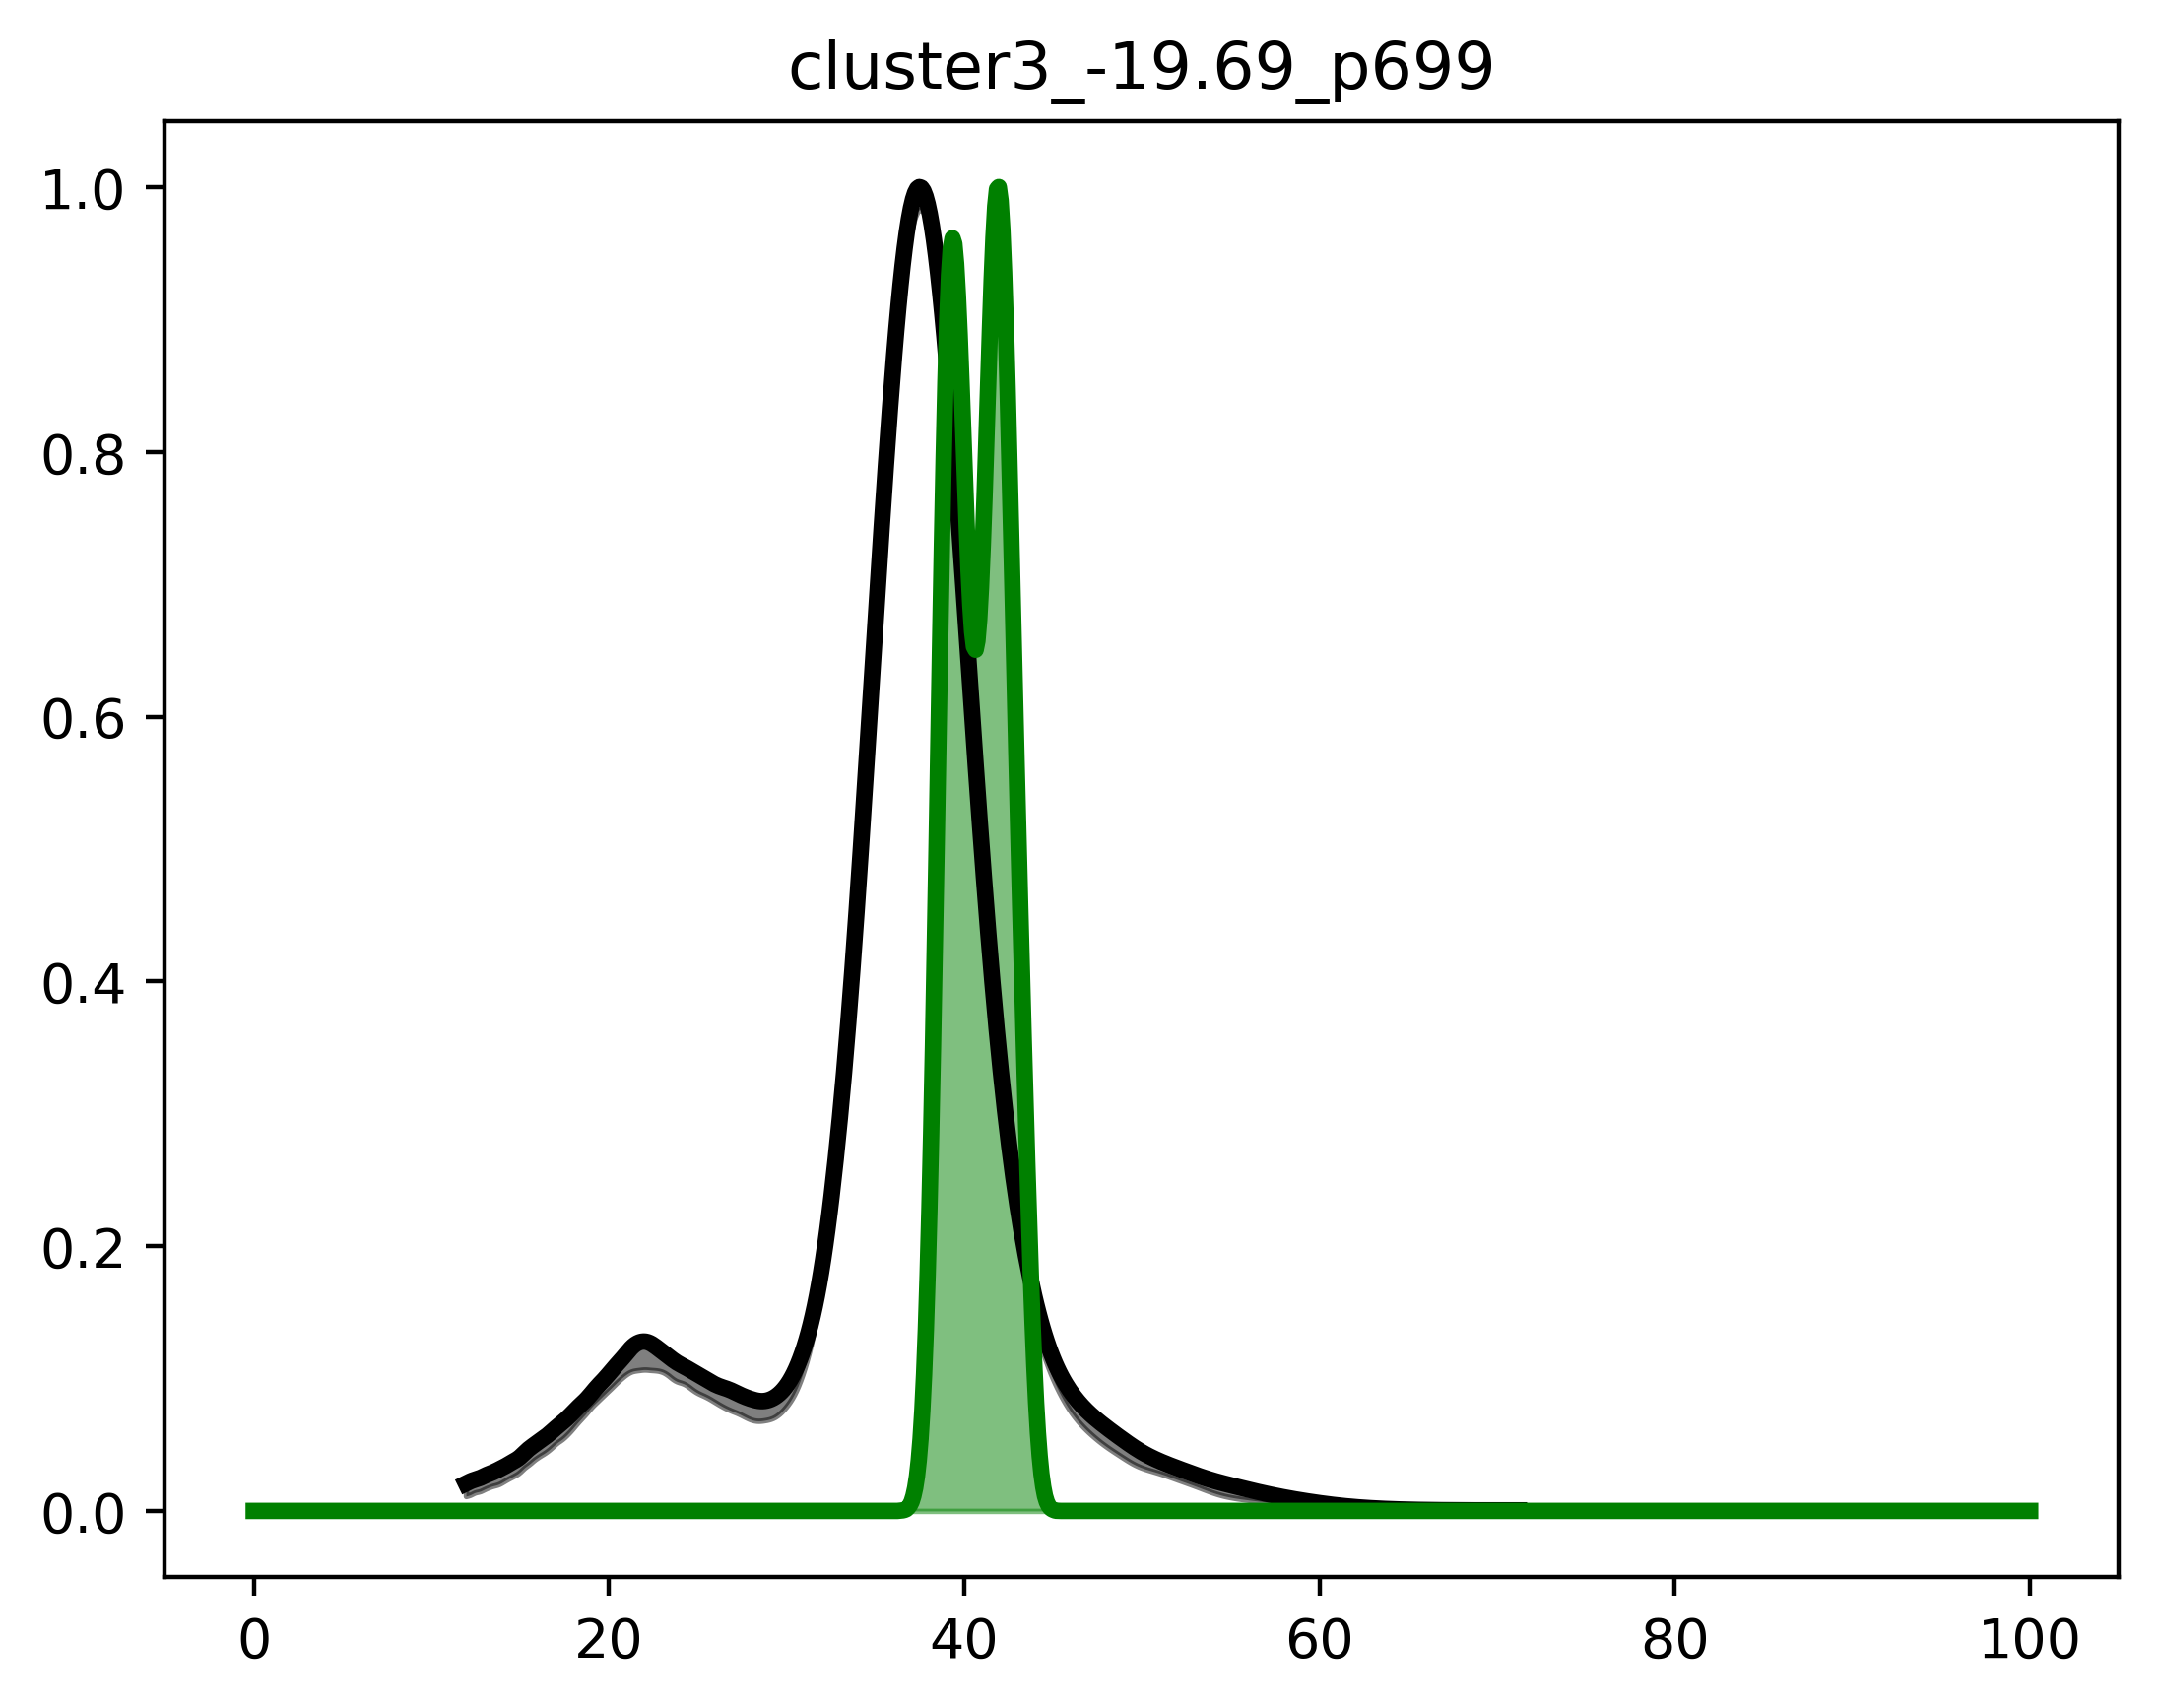

In [30]:
os.chdir(f"{TARGET_PATH}/{grid_name}1")

r = np.linspace(0, 100, 1000)
chosen_poses = [0,1,2] # Choose indexes of poses. Poses are sorteb by their binding energy
# Selection of atoms of ligand with spin density. Here we are going to choose N atoms
spin_atom_sele = "name N*" 
for idx in chosen_poses:
    fig, ax = plt.subplots(1,1,dpi=200)
    pdbfile = clustfile_pdb[idx]
    energy = run_energy[idx]
    pop = nclust[idx]
    lig = mda.Universe(f"{clusters_folder}/{pdbfile}")
    # UNL is the name of the residue of our ligand
    sel = lig.select_atoms(f"resname UNL")
    # for res in sel.residues:
    #         res.resname = "TMP"

    SL_lig = xl.IntrinsicLabel("UNL", sel, spin_atoms=sel.select_atoms("name N*"))
    P = xl.distance_distribution(SL_label, SL_lig, r=r, use_spin_centers=False,
        sigma=0.5)
    P/=max(P)
    ax.plot(distr[:,0],distr[:,1], label = 'Experimental', color='black', linewidth=3)
    ax.fill_between(distr[:,0], distr[:,1], distr[:,2], color='black', alpha=0.5)
    ax.plot(r, P, linewidth=3, color='green')
    ax.fill_between(r, np.zeros(len(r)), P, color='green', alpha=0.5)
    ax.set_title(pdbfile.split(".pdb")[0])
    fig.show()

And so we can compare results of our focused docking with experiments!

We can see that all poses correlate well with the experiment. However, the most populated pose seems to deviate slightly. Therefore, we probably should use the pose with the highest energy.

Now all that's left is to consider the mobility of the complex by performing MD!
